In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.orm import aliased
from sqlalchemy import desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [15]:
#Get the table information
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
#get column information for measurement table
m_col = inspector.get_columns('Measurement')
for c in m_col:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
#get column information for station table
s_col = inspector.get_columns('Station')
for c in s_col:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
import datetime as dt
from datetime import datetime, time

In [52]:
end_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
end_date

'2017-08-23'

In [53]:
# Calculate the date 1 year ago from the last data point in the database
def year_ago(date_str):
    new_date = datetime.strftime((datetime.strptime(date_str,'%Y-%m-%d') - dt.timedelta(days=365)).date(),'%Y-%m-%d')
    return new_date
start_date = year_ago(end_date)
start_date


'2016-08-23'

In [54]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       Measurement.prcp]
precip = session.query(*sel).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).\
order_by(Measurement.date).all()

In [62]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precip, columns=['date','precipitation'])
# Sort the dataframe by date
precipitation_df.sort_values('date')
precipitation_df.set_index('date', inplace=True)

precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


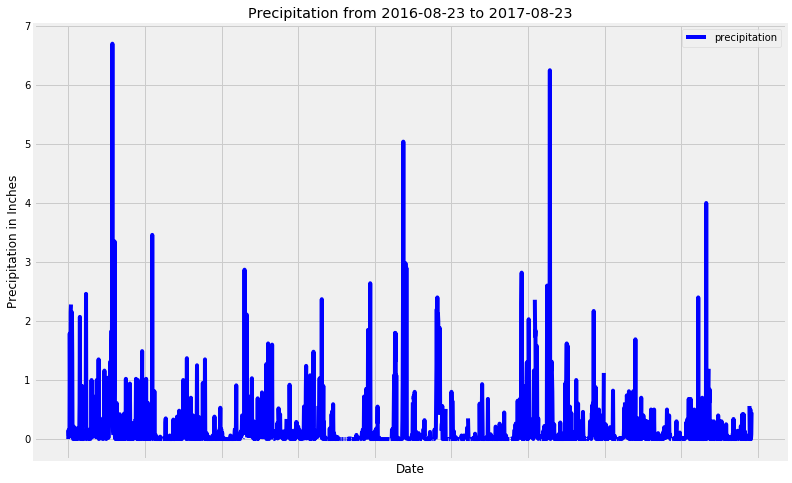

In [71]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(12,8), color='blue')
plt.ylabel('Precipitation in Inches')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=False,     
    top=False,        
    labelbottom=False) 
plt.autoscale(enable=True, axis='both')
plt.title(f"Precipitation from {start_date} to {last_date}")
plt.savefig("Images/Precipitation.png")

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(f'Precipitation summary for the period {start_date} to {end_date}')
precipitation_df.describe()

Precipitation summary for the period 2016-08-23 to 2017-08-23


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [73]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Available Stations Count: {available_stations} ")

Available Stations Count: 9 


In [74]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busiest_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
busiest_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_busy_station=busiest_stations[0][0]
busiest_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_busy_station).all()
print(f"Most Active Station Temperatures")
print(f"Low: {busiest_temps[0][0]} High: {busiest_temps[0][1]} Average: {round(busiest_temps[0][2], 1)}")

Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


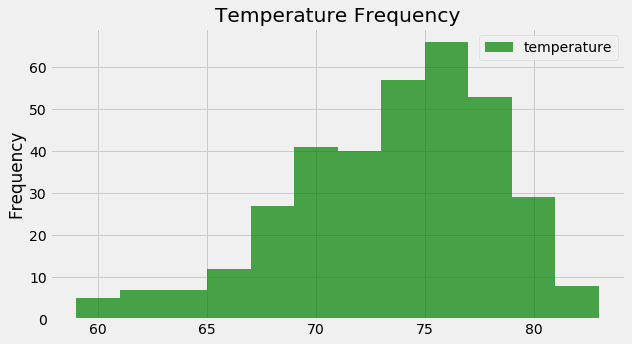

In [79]:
# Choose the station with the highest number of temperature observations.
highest_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).first()[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query( Measurement.tobs).filter(Measurement.date >= start_date).\
                    filter(Measurement.station == highest_temps_station).all()
temp_observations = pd.DataFrame(temp_observations, columns=['temperature'])
temp_observations.plot.hist(bins=12, title="Temperature Frequency",color='green', alpha=0.7, figsize=(9,5))
plt.tight_layout()
plt.style.use('fivethirtyeight')
plt.savefig("Images/Temperature_Frequency.png")
plt.show()

In [80]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = year_ago('2018-05-04')
trip_end = year_ago('2018-05-14')
last_year=calc_temps(trip_start, trip_end)
last_year

[(66.0, 75.37704918032787, 80.0)]

In [108]:
#explain output more clearly
trip_df = pd.DataFrame(last_year, columns=['tmin', 'tavg', 'tmax'])
tmin=last_year[0][0]
tavg=round(last_year[0][1],2)
tmax=last_year[0][2]

print(f'Last year at this time the average temperature was {tavg}. \
The High was {tmax} and the low was {tmin}')
      

Last year at this time the average temperature was 75.38. The High was 80.0 and the low was 66.0


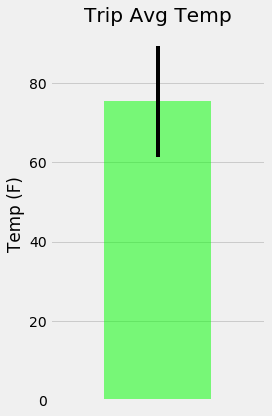

In [95]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(last_year, columns=['tmin', 'tavg', 'tmax'])

trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), title='Trip Avg Temp', color='lime', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()



In [99]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    select_column = [Measurement.station, 
               Station.name, 
               Station.latitude, 
               Station.longitude, 
               Station.elevation, 
               Measurement.prcp]

    return session.query(*select_column).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
print(precipitation(trip_start, trip_end))

[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.08), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, None)]


In [100]:
#clean up for readability
trip_precip=precipitation(trip_start, trip_end)
trip_rain = pd.DataFrame(trip_precip)
trip_rain

,station,name,latitude,longitude,elevation,prcp
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.08
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
2,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.00
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.00
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,NaN


## Optional Challenge Assignment

In [109]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [110]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2019-05-04'
end_date = '2019-05-14'
# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_len = (datetime.strptime(end_date,'%Y-%m-%d') - datetime.strptime(start_date,'%Y-%m-%d')).days + 1
trip_data = []
trip_dates = []
for date in range(0,trip_len):
    day = (datetime.strptime(start_date,'%Y-%m-%d') + dt.timedelta(days=date))
    trip_dates.append(datetime.strftime(day,'%m-%d'))
    trip_data.append(daily_normals(datetime.strftime(day,'%m-%d'))[0])

In [111]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_ave = pd.DataFrame(trip_data, columns=['Min Temp','Avg Temp','Max Temp'])
trip_ave['Date'] = trip_dates
trip_ave

,Min Temp,Avg Temp,Max Temp,Date
0,65.0,73.596491,78.0,05-04
1,67.0,73.396552,79.0,05-05
2,66.0,73.140351,80.0,05-06
3,64.0,71.788462,79.0,05-07
4,65.0,72.188679,80.0,05-08
5,67.0,72.932203,79.0,05-09
6,64.0,73.315789,78.0,05-10
7,65.0,73.611111,79.0,05-11
8,65.0,73.137931,79.0,05-12
9,67.0,73.142857,79.0,05-13


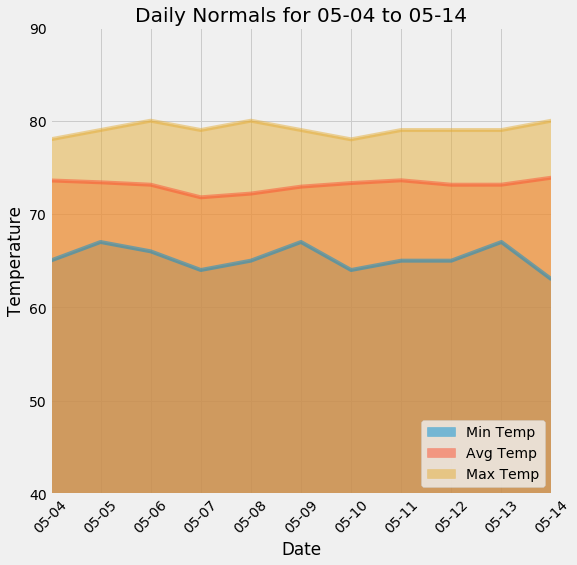

In [115]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_ave.plot(kind='area',stacked=False,figsize=(8,8),ylim=(40,90))
ax.set_xticks(range(len(trip_ave)))
ax.set_xticklabels(trip_ave['Date'], rotation=45)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(loc='lower right')
plt.title(f"Daily Normals for {trip_dates[0]} to {trip_dates[10]}")
plt.savefig('Images/daily_normals.png')